In [1]:
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from tqdm.notebook import tqdm
import pandas as pd
from scipy.integrate import trapezoid as trapz
import random

In [2]:
from time_vary_and_norm_simulators import psiam_tied_data_gen_wrapper_rate_norm_fn

In [3]:
from time_vary_norm_utils import up_or_down_RTs_fit_fn, up_or_down_RTs_fit_wrt_stim_fn

In [6]:
N_sim = int(1e5)
dt = 1e-4

V_A = 1.6
theta_A = 2.5
t_A_aff = -0.22
# t_A_aff = 0
# t_A_aff = 0.2

t_stim = 0.25

rate_lambda = 2
T_0 = 200 * 1e-3
theta_E = 3

t_E_aff = 0.068
# t_E_aff = 0
del_go = 0.13
# del_go = 0

rate_norm_l = 0.95

N_print = int(N_sim / 5)

ABL = 20
ILD = 2

Z_E = 0.15


In [7]:
# repeat_trial, T16, S7
og_df = pd.read_csv('../out_LED.csv')
df = og_df[ og_df['repeat_trial'].isin([0,2]) | og_df['repeat_trial'].isna() ]
session_type = 7    
df = df[ df['session_type'].isin([session_type]) ]
training_level = 16
df = df[ df['training_level'].isin([training_level]) ]


# t_stim, t_LED, ABL, ILD
t_stim_and_led_tuple = [(row['intended_fix'], row['intended_fix'] - row['LED_onset_time']) for _, row in df.iterrows()]
ABL_arr = df['ABL'].unique(); ABL_arr.sort()
ILD_arr = df['ILD'].unique(); ILD_arr.sort()


# 1 is right , -1 is left
df['choice'] = df['response_poke'].apply(lambda x: 1 if x == 3 else (-1 if x == 2 else random.choice([1, -1])))
# 1 or 0 if the choice was correct or not
df['correct'] = (df['ILD'] * df['choice']).apply(lambda x: 1 if x > 0 else 0)

# LED OFF
df_led_off = df[df['LED_trial'] == 0]
print(f'len of LED off: {len(df_led_off)}')



# valid trials
df_led_off_valid_trials = df_led_off[df_led_off['success'].isin([1,-1])]
print(f'len of led off valid trials = {len(df_led_off_valid_trials)}')

# remove trials with RT > 1s
df_led_off_valid_trials = df_led_off_valid_trials[df_led_off_valid_trials['timed_fix'] - df_led_off_valid_trials['intended_fix'] < 1]
print(f'len of valid trials < 1s : {len(df_led_off_valid_trials)}')

len of LED off: 66226
len of led off valid trials = 53472
len of valid trials < 1s : 52799


In [8]:
import numpy as np
import pandas as pd

# Step 1: Add abs_ILD and rt_wrt_stim to the dataframe
df_led_off_valid_trials['abs_ILD'] = df_led_off_valid_trials['ILD'].abs()
df_led_off_valid_trials['rt_wrt_stim'] = df_led_off_valid_trials['timed_fix'] - df_led_off_valid_trials['intended_fix']

# Step 2: Compute empirical mean RTs
empirical_rt = df_led_off_valid_trials.groupby(['ABL', 'abs_ILD'])['rt_wrt_stim'].median().reset_index()
empirical_rt.rename(columns={'rt_wrt_stim': 'data mean'}, inplace=True)


print('==========================================================')
print(f'lamda = {rate_lambda}, T_0 = {T_0 * 1e3} ms, theta_E = {theta_E}')
print('==========================================================')

# Step 4: Generate theoretical mean RTs
theoretical_rows = []
chi = 17.37
all_ABL = empirical_rt['ABL'].unique()
all_ILD = empirical_rt['abs_ILD'].unique()

for ABL in all_ABL:
    for ILD in all_ILD:
        lambda_ABL_term = (10 ** (rate_lambda * (1 - rate_norm_l) * ABL / 20))
        lambda_ILD_arg = rate_lambda * ILD / chi
        lambda_ILD_L_arg = rate_lambda * rate_norm_l * ILD / chi
        mu = (1 / T_0) * lambda_ABL_term * (np.sinh(lambda_ILD_arg) / np.cosh(lambda_ILD_L_arg))
        sigma_sq = (1 / T_0) * lambda_ABL_term * (np.cosh(lambda_ILD_arg) / np.cosh(lambda_ILD_L_arg))
        model_rt = (theta_E / mu) * np.tanh(mu * theta_E / sigma_sq)
        theoretical_rows.append({'ABL': ABL, 'abs_ILD': ILD, 'model_mean_RT': model_rt})

theoretical_rt = pd.DataFrame(theoretical_rows)

# Step 5: Merge and print side by side
merged = pd.merge(empirical_rt, theoretical_rt, on=['ABL', 'abs_ILD'])
print(merged)


lamda = 2, T_0 = 200.0 ms, theta_E = 3
    ABL  abs_ILD  data mean  model_mean_RT
0    20      1.0   0.297731       1.375083
1    20      2.0   0.287823       1.241103
2    20      4.0   0.263780       0.942313
3    20      8.0   0.197015       0.618777
4    20     16.0   0.158144       0.456267
5    40      1.0   0.226616       1.092267
6    40      2.0   0.214530       0.985843
7    40      4.0   0.190349       0.748506
8    40      8.0   0.160279       0.491512
9    40     16.0   0.138245       0.362426
10   60      1.0   0.188789       0.867619
11   60      2.0   0.185669       0.783083
12   60      4.0   0.174776       0.594559
13   60      8.0   0.152016       0.390422
14   60     16.0   0.129234       0.287885


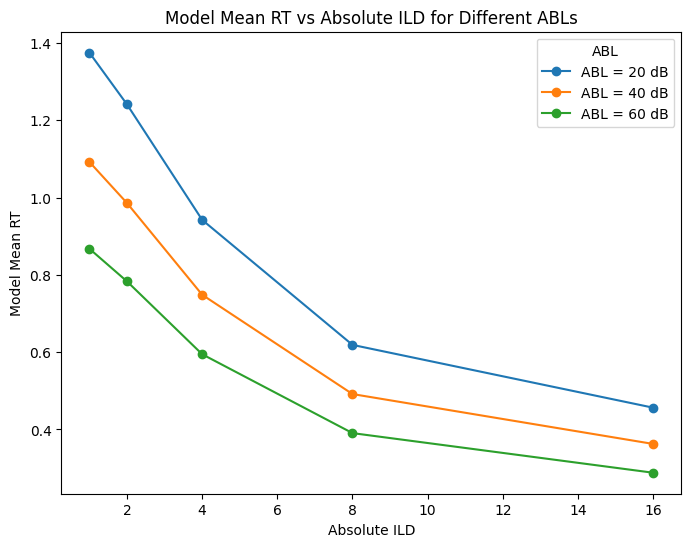

In [220]:
import matplotlib.pyplot as plt

# Assume `theoretical_rt` contains columns: ABL, abs_ILD, model_mean_RT

plt.figure(figsize=(8, 6))

for abl in sorted(theoretical_rt['ABL'].unique()):
    subset = theoretical_rt[theoretical_rt['ABL'] == abl]
    plt.plot(subset['abs_ILD'], subset['model_mean_RT'], marker='o', label=f'ABL = {abl} dB')

plt.xlabel('Absolute ILD')
plt.ylabel('Model Mean RT')
plt.title('Model Mean RT vs Absolute ILD for Different ABLs')
plt.legend(title='ABL')


# sim test params

In [9]:
ABL = 20
ILD = 1
t_stim = 0.25

# only norm

In [228]:
sim_results = Parallel(n_jobs=30)(
    delayed(psiam_tied_data_gen_wrapper_rate_norm_fn)(
        V_A, theta_A, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, t_A_aff, t_E_aff, del_go, 
        t_stim, rate_norm_l, iter_num, N_print, dt
    ) for iter_num in tqdm(range(N_sim))
)

  0%|          | 0/100000 [00:00<?, ?it/s]

os id: 1264397, In iter_num: 0, ABL: 20, ILD: 1, t_stim: 0.25
os id: 1264405, In iter_num: 20000, ABL: 20, ILD: 1, t_stim: 0.25
os id: 1264386, In iter_num: 40000, ABL: 20, ILD: 1, t_stim: 0.25
os id: 1264383, In iter_num: 60000, ABL: 20, ILD: 1, t_stim: 0.25
os id: 1264386, In iter_num: 80000, ABL: 20, ILD: 1, t_stim: 0.25


In [229]:
sim_results_df = pd.DataFrame(sim_results)
sim_df_up = sim_results_df[(sim_results_df['choice'] == 1)]
sim_df_down = sim_results_df[(sim_results_df['choice'] == -1)]
sim_rt_up = sim_df_up['rt'] - sim_df_up['t_stim']
sim_rt_down = sim_df_down['rt'] - sim_df_down['t_stim']
total_len = len(sim_rt_up) + len(sim_rt_down)

In [230]:
# theory
is_norm = True
is_time_vary = False
K_max = 10
t_pts = np.arange(-1, 4, 0.001)
theory_up = np.array([up_or_down_RTs_fit_fn(
                    t, 1,
                    V_A, theta_A, t_A_aff,
                    t_stim, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, t_E_aff, del_go,
                    np.nan, rate_norm_l, 
                    is_norm, is_time_vary, K_max) for t in t_pts])

theory_down = np.array([up_or_down_RTs_fit_fn(
                    t, -1,
                    V_A, theta_A, t_A_aff,
                    t_stim, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, t_E_aff, del_go,
                    np.nan, rate_norm_l, 
                    is_norm, is_time_vary, K_max) for t in t_pts])

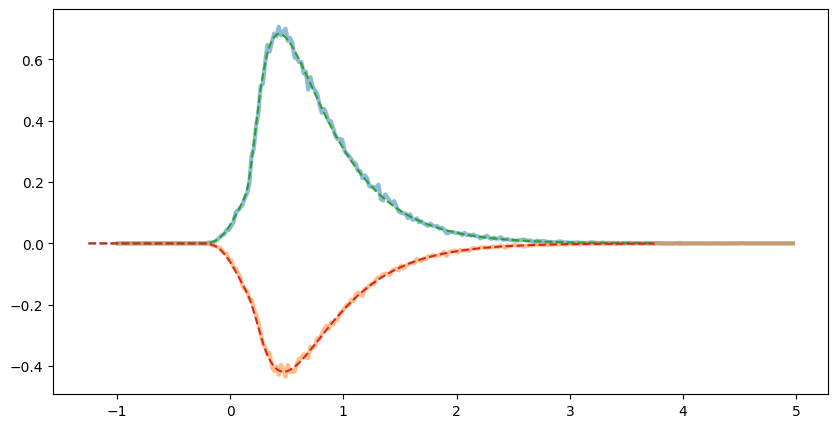

In [231]:
bw = 0.02
bins = np.arange(-1, 5, bw)
sim_rt_up_hist, _ = np.histogram(sim_rt_up, bins=bins, density=True)
sim_rt_down_hist, _ = np.histogram(sim_rt_down,bins=bins, density=True)
bin_centers = bins[:-1] + 0.5*bw
plt.figure(figsize=(10,5))
plt.plot(bin_centers, sim_rt_up_hist * len(sim_rt_up)/total_len, alpha=0.5, lw=3)
plt.plot(bin_centers, -sim_rt_down_hist * len(sim_rt_down)/total_len, alpha=0.5, lw=3)

plt.plot(t_pts - t_stim, theory_up, ls='--')
plt.plot(t_pts - t_stim, -theory_down, ls='--')


# norm & time vary

In [236]:
from time_vary_and_norm_simulators import psiam_tied_data_gen_wrapper_rate_norm_time_vary_fn, phi_t_fn

In [ ]:
from types import SimpleNamespace

bump_offset = 0
bump_width = 0.240
dip_width = 0.038
dip_height = 0.327

bump_height = 0.5

phi_params = {
    'h1': bump_width,
    'a1': bump_height,
    'h2': dip_width,
    'a2': dip_height,
    'b1': bump_offset
}

phi_params_obj = SimpleNamespace(**phi_params)

In [238]:
sim_results = Parallel(n_jobs=30)(
    delayed(psiam_tied_data_gen_wrapper_rate_norm_time_vary_fn)(
        V_A, theta_A, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, t_A_aff, t_E_aff, del_go, 
        t_stim, rate_norm_l, iter_num, N_print, phi_params_obj, dt
    ) for iter_num in tqdm(range(N_sim))
)

  0%|          | 0/100000 [00:00<?, ?it/s]

os id: 1264397, In iter_num: 0, ABL: 20, ILD: 1, t_stim: 0.25
os id: 1264397, In iter_num: 20000, ABL: 20, ILD: 1, t_stim: 0.25
os id: 1264400, In iter_num: 40000, ABL: 20, ILD: 1, t_stim: 0.25
os id: 1264403, In iter_num: 60000, ABL: 20, ILD: 1, t_stim: 0.25
os id: 1264399, In iter_num: 80000, ABL: 20, ILD: 1, t_stim: 0.25


In [239]:
sim_results_df = pd.DataFrame(sim_results)
# sim_df_up = sim_results_df[(sim_results_df['choice'] == 1) & (sim_results_df['rt'] > sim_results_df['t_stim'])]
# sim_df_down = sim_results_df[(sim_results_df['choice'] == -1) & (sim_results_df['rt'] > sim_results_df['t_stim'])]
sim_df_up = sim_results_df[(sim_results_df['choice'] == 1) ]
sim_df_down = sim_results_df[(sim_results_df['choice'] == -1) ]

sim_rt_up = sim_df_up['rt'] - sim_df_up['t_stim']
sim_rt_down = sim_df_down['rt'] - sim_df_down['t_stim']
total_len = len(sim_rt_up) + len(sim_rt_down)

In [240]:
# theory
is_norm = True
is_time_vary = True
K_max = 10
t_pts = np.arange(-1, 5, 0.001)
theory_up = np.array([up_or_down_RTs_fit_fn(
                    t, 1,
                    V_A, theta_A, t_A_aff,
                    t_stim, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, t_E_aff, del_go,
                    phi_params_obj, rate_norm_l, 
                    is_norm, is_time_vary, K_max) for t in t_pts])

theory_down = np.array([up_or_down_RTs_fit_fn(
                    t, -1,
                    V_A, theta_A, t_A_aff,
                    t_stim, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, t_E_aff, del_go,
                    phi_params_obj, rate_norm_l, 
                    is_norm, is_time_vary, K_max) for t in t_pts])

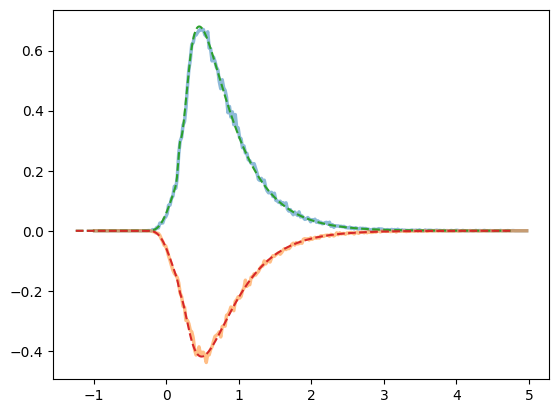

In [242]:
bw = 0.02
bins = np.arange(-1, 5, bw)
sim_rt_up_hist, _ = np.histogram(sim_rt_up, bins=bins, density=True)
sim_rt_down_hist, _ = np.histogram(sim_rt_down,bins=bins, density=True)
bin_centers = bins[:-1] + 0.5*bw
plt.plot(bin_centers, sim_rt_up_hist * len(sim_rt_up)/total_len, lw=2.5, alpha=0.5)
plt.plot(bin_centers, -sim_rt_down_hist * len(sim_rt_down)/total_len, lw=2.5, alpha=0.5)

plt.plot(t_pts - t_stim, theory_up, ls='--')
plt.plot(t_pts - t_stim, -theory_down, ls='--')

In [243]:
from time_vary_norm_utils import rho_A_t_VEC_fn
from scipy.integrate import cumulative_trapezoid as cumtrapz

N_theory = int(1e3)
pdf = rho_A_t_VEC_fn(t_pts - t_A_aff + t_stim, V_A, theta_A)

P_A_samples_mean =  pdf
C_A_mean = cumtrapz(P_A_samples_mean, t_pts, initial=0)

In [249]:
up_theory_2 = np.zeros_like(t_pts)
down_theory_2 = np.zeros_like(t_pts)
for idx, t in enumerate(t_pts):
    P_A = P_A_samples_mean[idx]
    C_A = C_A_mean[idx]
    up_theory_2[idx] = up_or_down_RTs_fit_wrt_stim_fn(
        t, 1,
        P_A, C_A,
        np.nan, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, t_E_aff, del_go,
        phi_params_obj, rate_norm_l,
        is_norm, is_time_vary, K_max)

    down_theory_2[idx] = up_or_down_RTs_fit_wrt_stim_fn(
        t, -1,
        P_A, C_A,
        np.nan, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, t_E_aff, del_go,
        phi_params_obj, rate_norm_l,
        is_norm, is_time_vary, K_max)

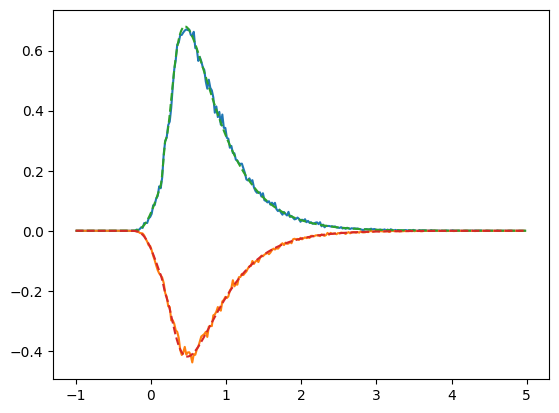

In [250]:
bw = 0.02
bins = np.arange(-1, 5, bw)
sim_rt_up_hist, _ = np.histogram(sim_rt_up, bins=bins, density=True)
sim_rt_down_hist, _ = np.histogram(sim_rt_down,bins=bins, density=True)
bin_centers = bins[:-1] + 0.5*bw
plt.plot(bin_centers, sim_rt_up_hist * len(sim_rt_up)/total_len)
plt.plot(bin_centers, -sim_rt_down_hist * len(sim_rt_down)/total_len)

plt.plot(t_pts, up_theory_2, ls='--')
plt.plot(t_pts, -down_theory_2, ls='--')

# check cdf?

In [246]:
from time_vary_norm_utils import cum_pro_and_reactive_time_vary_fn

In [247]:
tpts2 = np.arange(0, 5, 0.02)
cdf_theory = np.array([cum_pro_and_reactive_time_vary_fn(
                            t,
                            V_A, theta_A, t_A_aff,
                            t_stim, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, t_E_aff,
                            phi_params_obj, rate_norm_l, 
                            is_norm, is_time_vary, K_max) for t in tpts2])

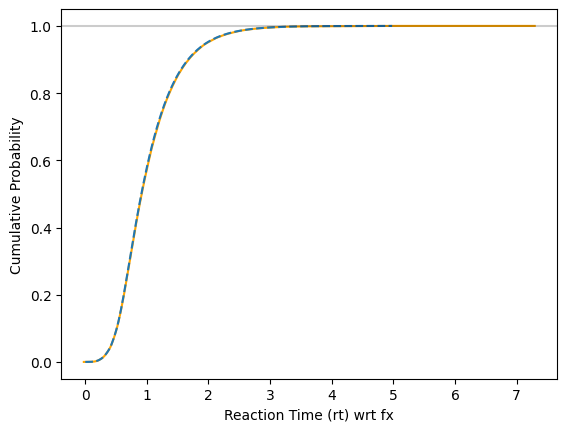

In [248]:
import numpy as np
import matplotlib.pyplot as plt

rt_values = np.sort(sim_results_df['rt'])
cdf = np.linspace(0, 1, len(rt_values))

plt.figure()
plt.plot(rt_values, cdf, label='Empirical CDF', color='orange')
plt.xlabel('Reaction Time (rt) wrt fx')
plt.ylabel('Cumulative Probability')



plt.plot(tpts2, cdf_theory, ls='--')
plt.axhline(1, alpha=0.2, color='k')

# only time vary, no norm

In [23]:
from time_vary_and_norm_simulators import psiam_tied_data_gen_wrapper_rate_norm_time_vary_fn, phi_t_fn

In [24]:
from types import SimpleNamespace

bump_offset = 0
bump_width = 0.240
dip_width = 0.038
dip_height = 0.327

bump_height = 0.5

phi_params = {
    'h1': bump_width,
    'a1': bump_height,
    'h2': dip_width,
    'a2': dip_height,
    'b1': bump_offset
}

phi_params_obj = SimpleNamespace(**phi_params)

In [25]:
is_norm = False
is_time_vary = True
rate_norm_l = 0

In [26]:
rate_lambda = 0.13
T_0 = 0.45 * 1e-3
theta_E = 45


In [27]:
sim_results = Parallel(n_jobs=30)(
    delayed(psiam_tied_data_gen_wrapper_rate_norm_time_vary_fn)(
        V_A, theta_A, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, t_A_aff, t_E_aff, del_go, 
        t_stim, rate_norm_l, iter_num, N_print, phi_params_obj, dt
    ) for iter_num in tqdm(range(N_sim))
)

  0%|          | 0/100000 [00:00<?, ?it/s]

os id: 2704116, In iter_num: 0, ABL: 20, ILD: 1, t_stim: 0.25
os id: 2704119, In iter_num: 20000, ABL: 20, ILD: 1, t_stim: 0.25
os id: 2704135, In iter_num: 40000, ABL: 20, ILD: 1, t_stim: 0.25
os id: 2704126, In iter_num: 60000, ABL: 20, ILD: 1, t_stim: 0.25
os id: 2704122, In iter_num: 80000, ABL: 20, ILD: 1, t_stim: 0.25


In [28]:
sim_results_df = pd.DataFrame(sim_results)
# sim_df_up = sim_results_df[(sim_results_df['choice'] == 1) & (sim_results_df['rt'] > sim_results_df['t_stim'])]
# sim_df_down = sim_results_df[(sim_results_df['choice'] == -1) & (sim_results_df['rt'] > sim_results_df['t_stim'])]
sim_df_up = sim_results_df[(sim_results_df['choice'] == 1) ]
sim_df_down = sim_results_df[(sim_results_df['choice'] == -1) ]

sim_rt_up = sim_df_up['rt'] - sim_df_up['t_stim']
sim_rt_down = sim_df_down['rt'] - sim_df_down['t_stim']
total_len = len(sim_rt_up) + len(sim_rt_down)

In [35]:
### does changing is_norm=True and L = 0 change things?
is_norm = False
rate_norm_l = np.nan

In [36]:
# theory
K_max = 10
t_pts = np.arange(-1, 5, 0.001)
theory_up = np.array([up_or_down_RTs_fit_fn(
                    t, 1,
                    V_A, theta_A, t_A_aff,
                    t_stim, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, t_E_aff, del_go,
                    phi_params_obj, rate_norm_l, 
                    is_norm, is_time_vary, K_max) for t in t_pts])

theory_down = np.array([up_or_down_RTs_fit_fn(
                    t, -1,
                    V_A, theta_A, t_A_aff,
                    t_stim, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, t_E_aff, del_go,
                    phi_params_obj, rate_norm_l, 
                    is_norm, is_time_vary, K_max) for t in t_pts])

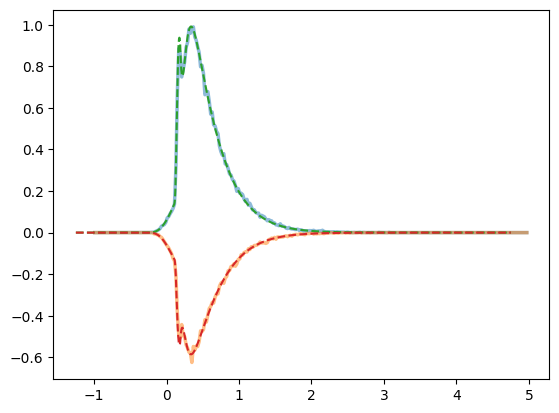

In [37]:
bw = 0.02
bins = np.arange(-1, 5, bw)
sim_rt_up_hist, _ = np.histogram(sim_rt_up, bins=bins, density=True)
sim_rt_down_hist, _ = np.histogram(sim_rt_down,bins=bins, density=True)
bin_centers = bins[:-1] + 0.5*bw
plt.plot(bin_centers, sim_rt_up_hist * len(sim_rt_up)/total_len, lw=2.5, alpha=0.5)
plt.plot(bin_centers, -sim_rt_down_hist * len(sim_rt_down)/total_len, lw=2.5, alpha=0.5)

plt.plot(t_pts - t_stim, theory_up, ls='--')
plt.plot(t_pts - t_stim, -theory_down, ls='--')